In [5]:
import numpy as np
import astropy.units as u
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from pathlib import Path
from IPython.display import clear_output, display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

from importlib import reload

import poppy

import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
poppy_log.disabled = True

import scoobpsf
from scoobpsf.math_module import xp, _scipy
from scoobpsf.imshows import *
from scoobpsf import scoob

import lina

pupil_diam = 6.75*u.mm 
lyot_diam = 8.7*u.mm

wavelength_c = 632.8e-9*u.m # central wavelength
npix = 512
oversample = 4

reload(scoobpsf.agpm)
vortex = scoobpsf.agpm.IdealAGPM(name='VVC', wavelength=wavelength_c, charge=6, singularity=20*u.um)
lyot_stop = poppy.CircularAperture(name='Lyot Stop', radius=lyot_diam/2.0)

No OPD data implemented into model.
Using default Gaussian influence function.
Including factor of 2 from reflection when computing OPD.


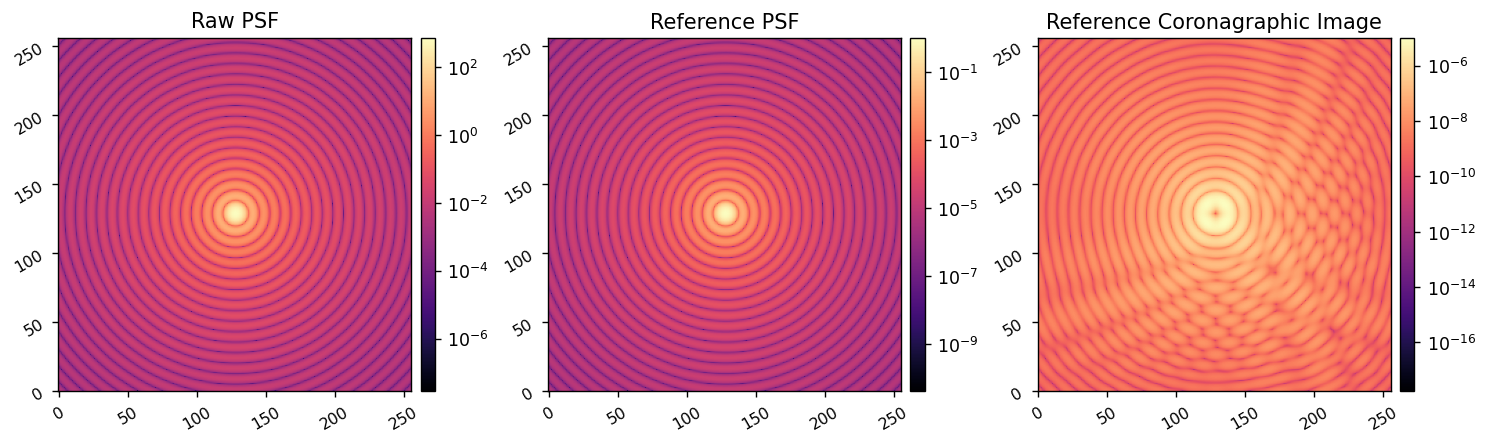

In [6]:
reload(scoob)
model = scoob.SCOOBM()

raw_psf = model.snap()
model.Imax_ref = xp.max(raw_psf)

ref_psf = model.snap()

model.FPM = vortex
model.LYOT = lyot_stop

ref_im = model.snap()

imshow3(raw_psf, ref_psf, ref_im, 
        'Raw PSF', 'Reference PSF', 'Reference Coronagraphic Image',
        lognorm=True)


In [46]:
reload(scoobpsf.dm)

<module 'scoobpsf.dm' from '/home/kianmilani/Projects/scoob-psf/scoobpsf/dm.py'>

In [7]:
reload(scoob)
model = scoob.SCOOBM()

wfs = model.calc_wfs()

No OPD data implemented into model.
Using default Gaussian influence function.
Including factor of 2 from reflection when computing OPD.
Propagating wavelength 632.800 nm.
PSF calculated in 0.148s


In [50]:
model.npix/34

7.529411764705882

7.529411764705882

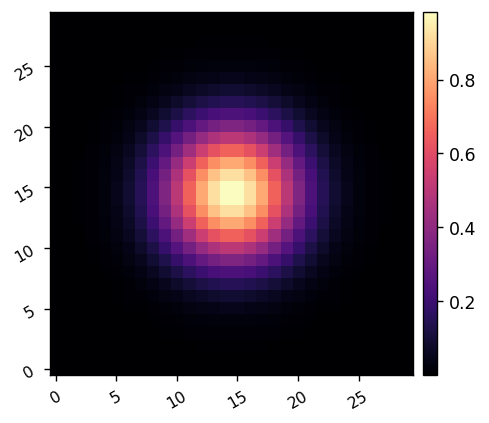

In [8]:
display(model.DM.inf_sampling)
imshow1(model.DM.inf_fun)


Pupil Diameter: 6.75 mm


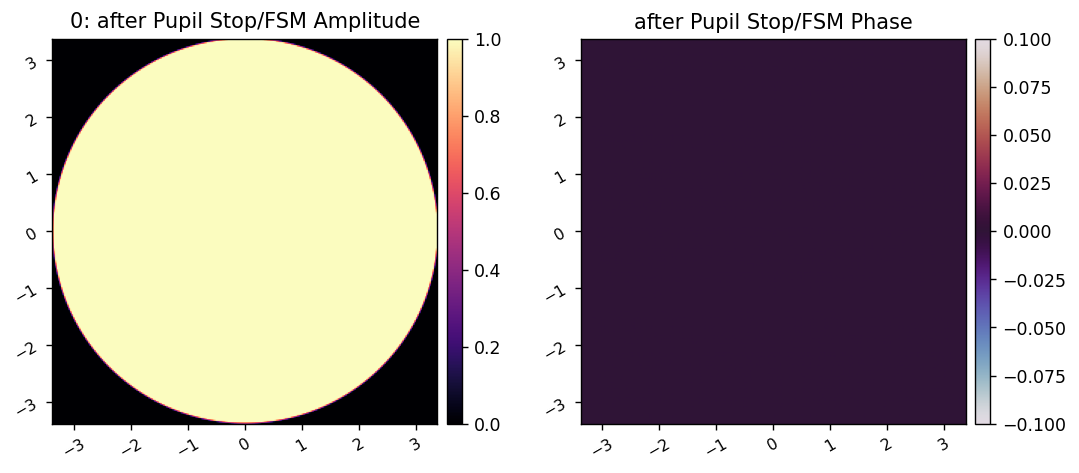

Correction distance: -0.00064053 mm


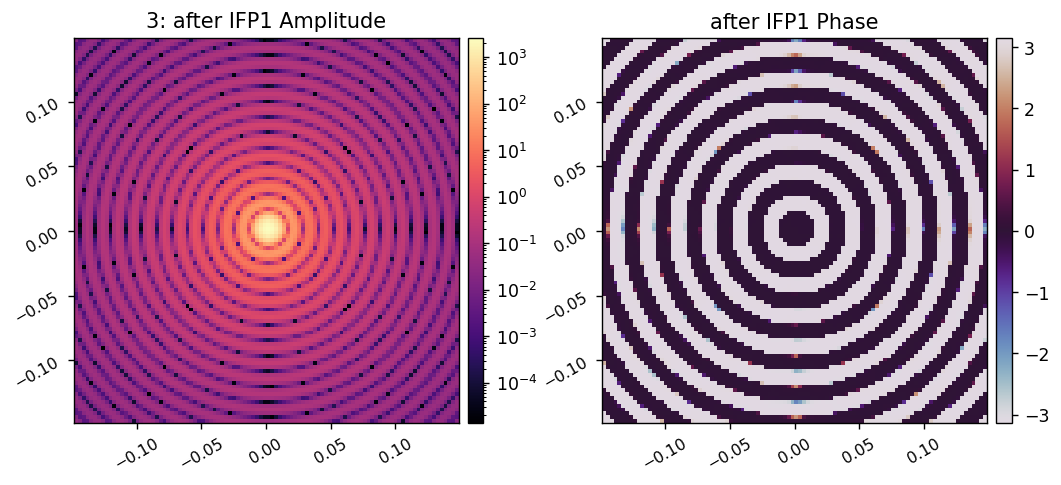

Pupil Diameter: 9.194962309464877 mm


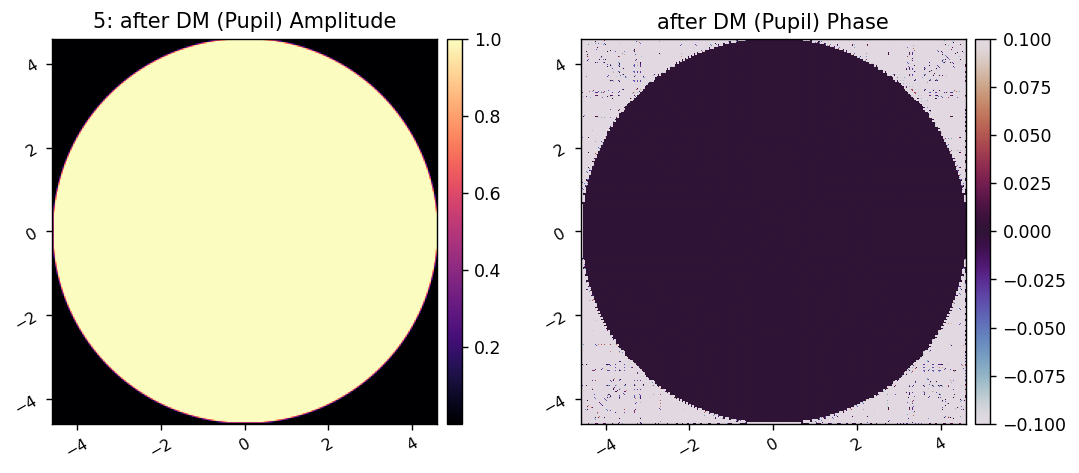

Correction distance: -0.00867902 mm


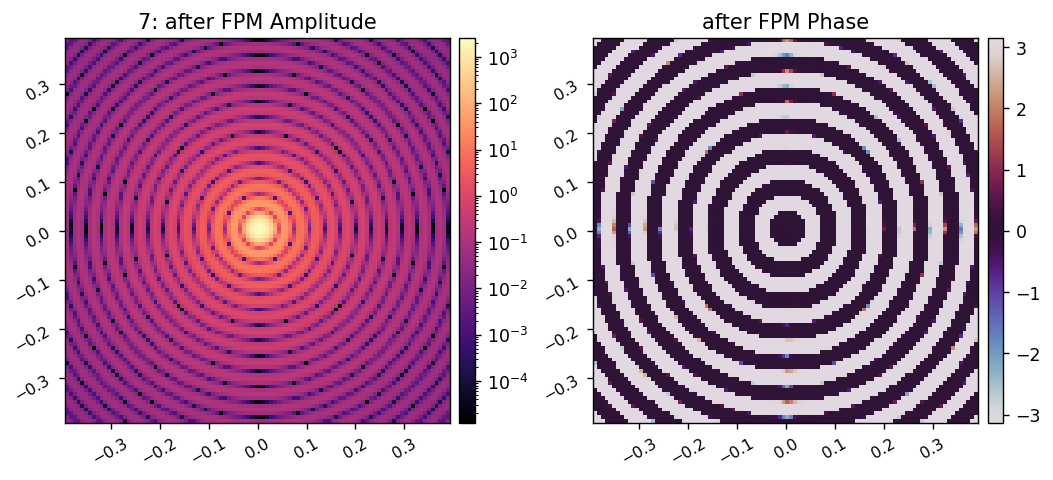

Pupil Diameter: 9.19128904217516 mm


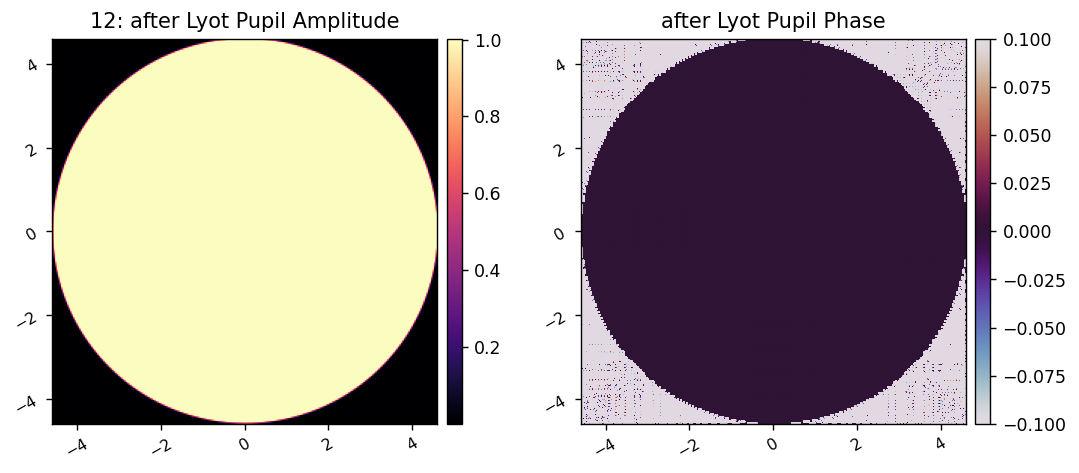

Correction distance: -0.00047103 mm


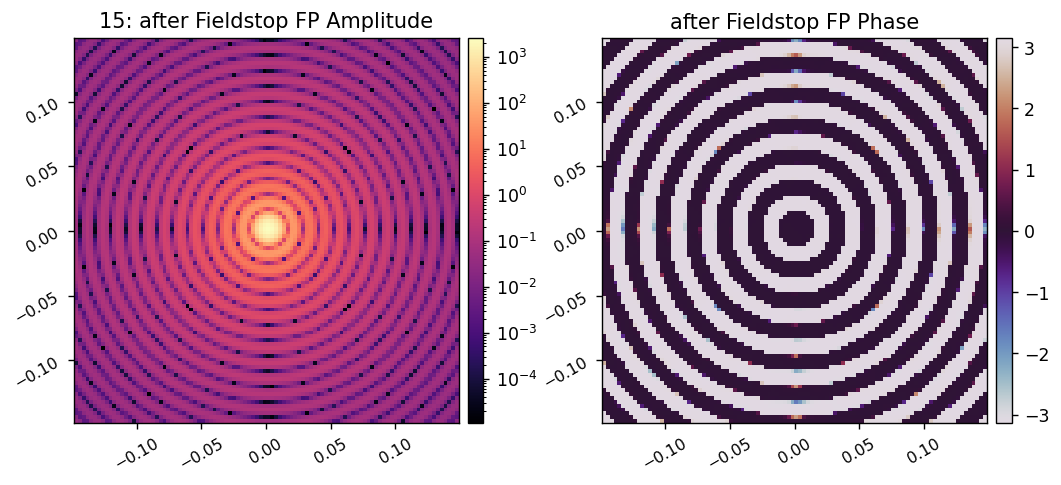

Correction distance: -0.00886959 mm


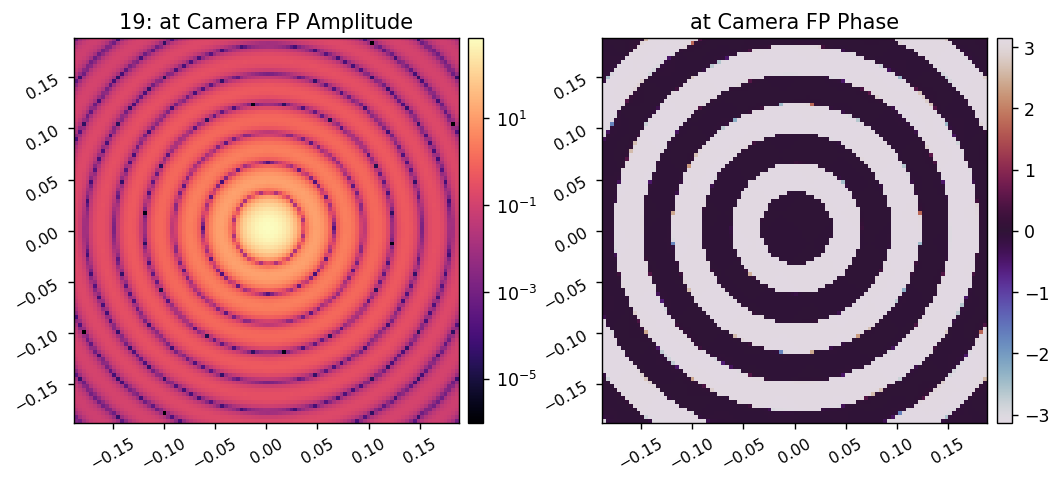

In [9]:
for i,wf in enumerate(wfs):
    if 'fp' in wf.location.lower():
        print(f'Correction distance: {(wf.z_w0 - wf.z).to(u.mm):.8f}')
        npix = 100
        imshow2(wf.intensity, wf.phase, f'{i:d}: ' + wf.location + ' Amplitude', wf.location+' Phase',
                lognorm1=True,
                cmap2='twilight',
                npix=npix, pxscl=wf.pixelscale.to(u.mm/u.pix)
                )
    elif 'pupil' in wf.location.lower():
        diam = wf.pixelscale.to(u.mm/u.pix) * model.npix*u.pix
        print(f'Pupil Diameter: {diam}')
        imshow2(wf.amplitude, wf.phase, f'{i:d}: ' + wf.location + ' Amplitude', wf.location+' Phase',
                cmap2='twilight',
                npix=model.npix, pxscl=wf.pixelscale.to(u.mm/u.pix),
                vmin2=-0.1, vmax2=0.1, 
                )

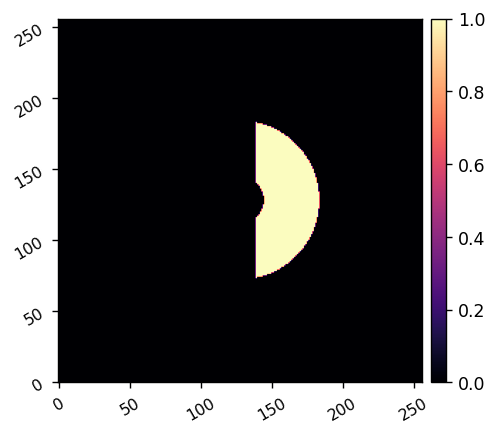

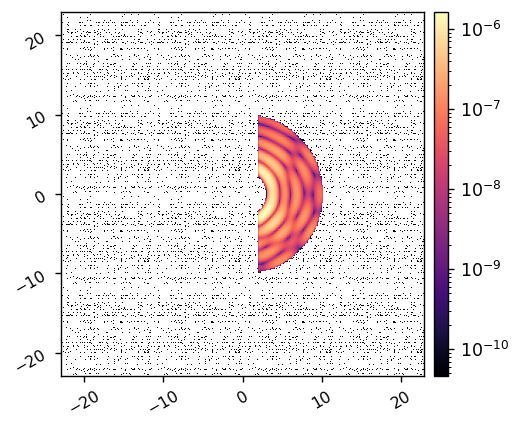

In [11]:
iwa = 3
owa = 10

control_mask = lina.utils.create_annular_focal_plane_mask(model, iwa, owa, edge=2, shift=(0,0), rotation=0, plot=True)
imshow1(ref_im*control_mask, lognorm=True, pxscl=model.psf_pixelscale_lamD)

In [13]:
poke_modes = lina.utils.create_all_poke_modes(model.dm_mask)

Calculating Jacobian: 
	Calculated response for mode 952/952. Elapsed time=257.563 sec.
Jacobian built in 257.563 sec


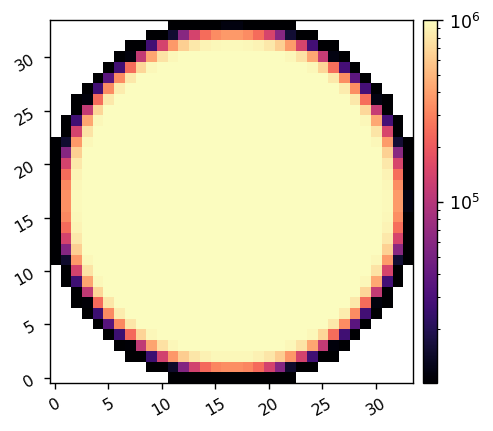

In [17]:
reload(lina.efc)

model.reset_dm()
calib_amp = 1e-9 # poke amplitudes (DM surface)
jac = lina.efc.calibrate(model, xp.array(poke_modes), calib_amp, control_mask, plot=True)

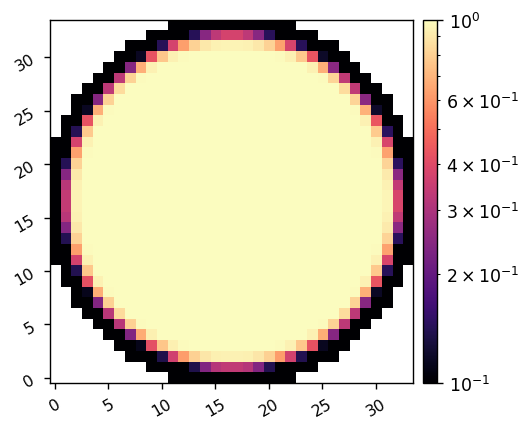

In [27]:
rms = np.sqrt(np.mean(np.square(ensure_np_array(jac).dot(poke_modes)), axis=0))
rms /= np.max(rms)
imshow1(rms.reshape(model.Nact, model.Nact), lognorm=True, vmin=1e-1)

In [1]:
!nvidia-smi


Fri Mar 15 15:47:39 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.14              Driver Version: 550.54.14      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100 80GB PCIe          Off |   00000000:25:00.0 Off |                    0 |
| N/A   34C    P0             63W /  300W |   61325MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----